# Universal Plots

Aka parallel coordinates are just scatter plots in disguise...

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import numpy as np
np.random.seed(0)

import linear_algebra_helpers as la

In [2]:
# Generate some random data...
M = 25
data_1d = np.random.randn(M, 1)
data_2d = np.random.randn(M, 2)
data_3d = np.random.randn(M, 3)

In a conventional plotting library, we could plot like this:

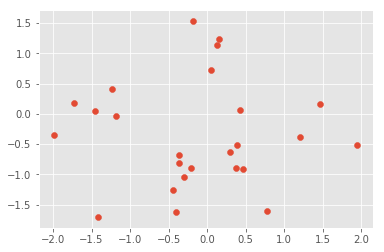

In [3]:
x, y = data_2d.T
plt.scatter(x, y)
plt.show()

#### Problems
There are several problems with this approach:
- How do we plot 1-, 3-, or n-dimensional data?
- How do we plot scatterplot matrix, parallel coordinates, radar plots, radvis etc.?

#### Typical Solution
Different plotting methods for different dimensions and visualisation types.

#### Idea
What if we could have a single, simple interface that covers all these use cases?

In [4]:
def plot_nd(positions, transform, size=None):
    size = (10,10) if size is None else size
    fig, ax = plt.subplots(figsize=size)
    
    # "Normalised Coordinates"
    ax.set_xlim(-1.0, +1.0)
    ax.set_ylim(-1.0, +1.0)
    
    # Transform and draw points
    view = positions @ transform
    x, y = view.T
    ax.scatter(x, y)
    
    plt.axis('off')
    plt.show()

What have we gained so far?

We can plot 1-, 2-, ..., n-dimensional data with the same function:

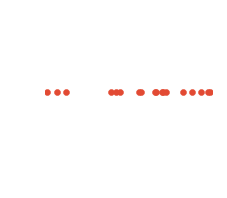

In [5]:
plot_nd(data_1d, np.eye(1,2), size=(3,3))

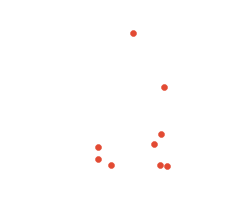

In [6]:
plot_nd(data_2d, np.eye(2,2), size=(3,3))

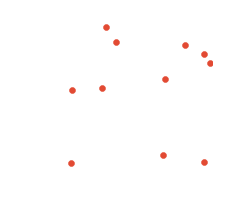

In [7]:
plot_nd(data_3d, np.eye(3,2), size=(3,3))

We can apply arbitrary linear transformations (e.g. non-uniform scale):

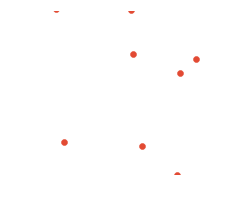

In [8]:
model_3d = np.array([[1.5,0,0],[0,1,0],[0,0,1]]) # Scale
model_2d = np.array([[0,-1],[1,0]]) # Rotate
plot_nd(data_3d, model_3d @ np.eye(3,2) @ model_2d, size=(3,3))

Limitations:
- Dimension of the display space is fixed to 2. (Generalising is straight forward and left as excercise for the reader.)
- Only linear transformations possible, in particular no translation. (See next section.)

### Homogeneous Coordinates
Update plotting function to use homogeneous coordinates. This allows us to represent affine transformations as matrices.

In [9]:
def plot_hnd(points, transform, size=None):
    size = (10,10) if size is None else size
    fig, ax = plt.subplots(figsize=size)
    
    # "Normalised Device Coordinates"
    ax.set_xlim(-1.0, +1.0)
    ax.set_ylim(-1.0, +1.0)
    
    # Transform and draw points
    view = points @ transform
    x, y, w = view.T
    ax.scatter(x/w, y/w)
    
    plt.axis('off')
    plt.show()

Convert data to use homogeneous coordinates, i.e. (n+1)-dimensional coordinates.

In [10]:
data_h1d = np.concatenate((data_1d, np.ones((M,1))), axis=1)
data_h2d = np.concatenate((data_2d, np.ones((M,1))), axis=1)
data_h3d = np.concatenate((data_3d, np.ones((M,1))), axis=1)

In [11]:
# Example: Normalise from [min, max] to [-1, +1] range...
def transform_normalise(data):
    lower = np.amin(data[:,:-1], axis=0)
    upper = np.amax(data[:,:-1], axis=0)
    delta = (upper - lower)
    return la.transform_translate(-lower) @ la.transform_scale(2/delta) @ la.transform_translate(-np.ones(lower.shape))

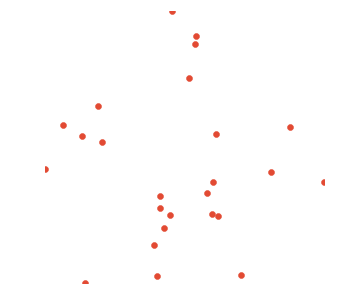

In [12]:
model = la.transform_normalise(data_h2d)
projection = la.transform_identity(2,2)
plot_hnd(data_h2d, model @ projection, size=(5,5))

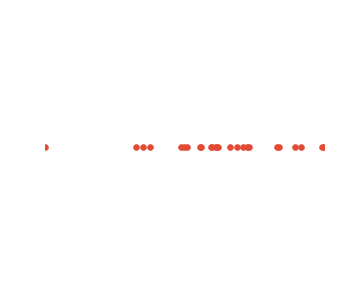

In [13]:
model = la.transform_normalise(data_h1d)
projection = la.transform_orthogonal_projection(1, 2, [0])
plot_hnd(data_h1d, model @ projection, size=(5,5))

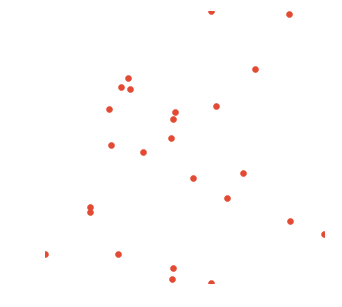

In [14]:
model = la.transform_normalise(data_h3d)
projection = la.transform_orthogonal_projection(3, 2, [0,2])
plot_hnd(data_h3d, model @ projection, size=(5,5))

### Multiple Coordinates
Update plotting function to use multiple coordinates. This allows us to draw the same points multiple times using different tranforms.

In [15]:
def plot_mhnd(points, transforms, size=None, join=False):
    size = (10,10) if size is None else size
    fig, ax = plt.subplots(figsize=size)
    
    # "Normalised Device Coordinates"
    ax.set_xlim(-1.0, +1.0)
    ax.set_ylim(-1.0, +1.0)
    
    cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    color = cycle[0]
    
    # Transform and draw points
    views = [points @ transform for transform in transforms]
    for view in views:
        x, y, w = view.T
        ax.scatter(x/w, y/w, c=color)
    
    # Optional: Join views...
    if join:
        for j in range(len(points)):
            path = np.array([views[i][j] for i in range(len(views))])
            x, y, w = path.T 
            ax.plot(x, y, c=color)
    
    plt.axis('off')
    plt.show()

#### Scatterplot

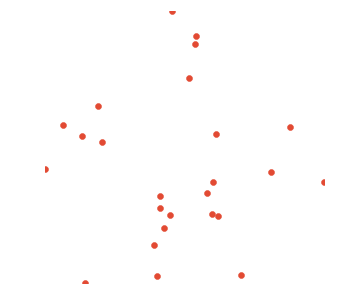

In [16]:
model = la.transform_normalise(data_h2d)
plot_mhnd(data_h2d, [model], size=(5,5))

#### Parallel Coordinates

In [48]:
def parallel_coordinates(n, i):
    dx = (2.0 * i/(n-1) - 1)
    return la.transform_orthogonal_projection(n, 2, [None, i]) @ la.transform_translate([dx*0.5, 0])

model_2d = la.transform_normalise(data_h2d)
transform0 = model_2d @ parallel_coordinates(2, 0) 
transform1 = model_2d @ parallel_coordinates(2, 1)
transforms = [transform0, transform1]

The first transform projects the first component onto the vertical axis and translates it left. The second transform projects the second component onto the vertical axis and translates it right.

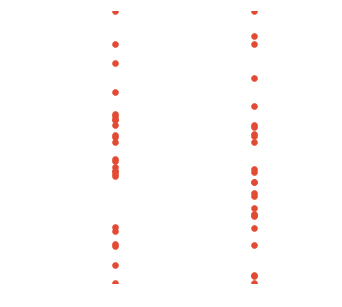

In [49]:
plot_mhnd(data_h2d, transforms, size=(5,5), join=False)

Almost looks like parallel coordinates, but not quite, since the connecting lines are missing.

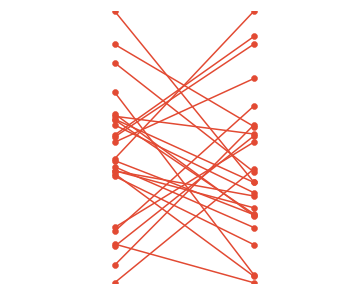

In [50]:
plot_mhnd(data_h2d, transforms, size=(5,5), join=True)

That's more like it...

#### Scatterplot Matrix

In [40]:
def scatterplot_matrix(i, j):
    s = la.transform_scale([0.25, 0.25, 0.25])
    t = la.transform_translate([i-1, j-1])
    return s @ la.transform_orthogonal_projection(3, 2, [i, j]) @ t

model_3d = la.transform_normalise(data_h3d)
model_2d = la.transform_scale([0.75, 0.75])
transforms = [(model_3d @ scatterplot_matrix(i, j) @ model_2d) for i, j in np.ndindex(3,3)]

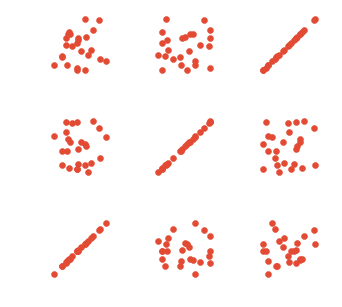

In [41]:
plot_mhnd(data_h3d, transforms, size=(5,5))

Not really useful, but just for fun, let's try joining the scatterplot matrix:

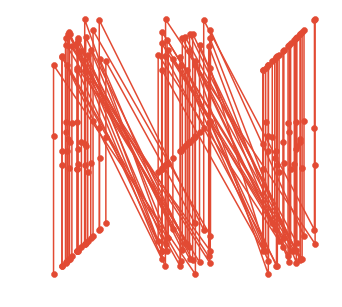

In [42]:
plot_mhnd(data_h3d, transforms, size=(5,5), join=True)

### Result

We have defined a single function `plot_mhnd` that accepts a set of positions ((n+1)-dimensional vectors) and a set of transforms ((n+1) x (m+1)), where n is the dimension of the data space, and m is the dimension of the visualisation space (i.e. in these examples set to 2). We have also introduced the concept of join geometries, which connect instances of the same mark across multiple views.

This is a very versatile plotting function. The "visualisation type" is completely determined by the transforms passed (and a flag indicating whether the point instances in different views should be joined). This function covers a vast array of use cases, such as parallel coorinates with arbitrary positioning of the coordinate axes (such as ImAxes).

The purpose of this notebook is just to illustrate the core technique for plotting n-dimensional data with flexible transformations. The technique could be easily extended to include other visual attributes such as colors and sizes. Furthermore, it is possible to draw axes, labels and so forth. This is left as an excercise for the reader.